In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [32]:
# refer: 
# "https://www.kaggle.com/c/expedia-hotel-recommendations/data"
# "https://medium.com/@wesleyklock/expedia-hotel-recommendations-ea6a9d5fbaa7"    
# "https://www.kaggle.com/dvasyukova/predict-hotel-type-with-pandas"

    
dataUri = "gs://bigdata-proj/train.csv"
trainUri = "gs://bigdata-proj/expedia-hotel-recommendations_train_train.csv"
testUri = "gs://bigdata-proj/expedia-hotel-recommendations_train_test.csv"

train = pd.read_csv(trainUri,
                    dtype={'is_booking':bool,'srch_destination_id':np.int32, 'hotel_cluster':np.int32},
                    usecols=['srch_destination_id','is_booking','hotel_cluster'],
                    chunksize=1000000)
datas = []
for chunk in train:
    data = chunk.groupby(['srch_destination_id',
                         'hotel_cluster'])['is_booking'].agg(['sum','count'])
    data.reset_index(inplace=True)
    datas.append(data)
datas = pd.concat(datas, axis=0)


test = pd.read_csv(testUri,
                    dtype={'srch_destination_id':np.int32, 'hotel_cluster':np.int32},
                    usecols=['srch_destination_id', 'hotel_cluster'],)

--------------------------------------
.............................


In [33]:
def most_popular(group, n_max=5):
    relevance = group['popularity'].values
    hotel_cluster = group['hotel_cluster'].values
    most_popular = hotel_cluster[np.argsort(relevance)[::-1]][:n_max]
    return np.array_str(most_popular)[1:-1]

In [34]:
def calculate(weight):
    CLICK_WEIGHT = weight
    data = datas.groupby(['srch_destination_id','hotel_cluster']).sum().reset_index()
    data['count'] -= data['sum']
    data = data.rename(columns={'sum':'bookings','count':'clicks'})
    data['popularity'] = data['bookings'] + CLICK_WEIGHT * data['clicks']


    most_pop = data.groupby(['srch_destination_id']).apply(most_popular)
    most_pop = pd.DataFrame(most_pop).rename(columns={0:'hotel_cluster'})
    # most_pop.head()

    y_test = test['hotel_cluster']
    x_test = test.drop('hotel_cluster', axis = 1)
    x_test = x_test.merge(most_pop, how='left',left_on='srch_destination_id',right_index=True)

    most_pop_all = data.groupby('hotel_cluster')['popularity'].sum().nlargest(5).index
    most_pop_all = np.array_str(most_pop_all)[1:-1]
    x_test.hotel_cluster.fillna(most_pop_all,inplace=True)

    correctness = 0
    for target, (index, row) in zip(y_test, x_test.iterrows()):
        clusters = row['hotel_cluster'].split()
    #     print(target)
    #     print(clusters)
        if str(target) in clusters:
            correctness += 1
    #         print('aa')  
    print(correctness)
    print(correctness / len(y_test))
    return (correctness / len(y_test))

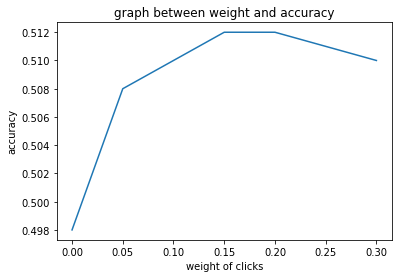

In [6]:
x = []
y = []
for i in range(7):
    x.append(i*0.05)
    y.append(calculate(i * 0.05))
plt.plot(x, y) 
plt.xlabel('weight of clicks')
plt.xlabel('accuracy')
plt.title('graph between weight and accuracy')
plt.show()

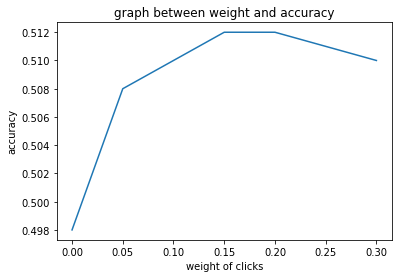

,srch_destination_id,hotel_cluster
0,12450,59 95 18 91 49
1,40890,95 4 28 72 9
2,30063,48 91 51 72 42
3,1763,81 58 43 61 85
4,12452,13 91 28 16 32


4251094
0.4514001164206408


     |████████████████████████████████| 71kB 5.5MB/s eta 0:00:011
  Found existing installation: fsspec 0.5.2
    Uninstalling fsspec-0.5.2:
      Successfully uninstalled fsspec-0.5.2


,srch_destination_id,hotel_cluster
0,12450,59 95 18 91 49
1,40890,95 4 28 72 9
2,30063,48 91 51 72 42
3,1763,81 58 43 61 85
4,12452,13 91 28 16 32
